In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns

import candas as can
import gumbi as gmb
from candas.lims import Librarian, library
from candas.learn import ParameterSet

base_pth, code_pth, data_pth, rslt_pth, fig_pth = can.utils.setup_paths(make_missing=False)
plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
import dill

In [3]:
ps = ParameterSet.load(data_pth / 'ADVI_ParameterSets_220528.pkl')
def make_pair(row):
    return '-'.join(sorted([row.FPrimer, row.RPrimer]))

data = (ps.wide
        .query('Metric == "mean"')
        .astype({'BP': float})
        .assign(PrimerPair = lambda df: df.apply(make_pair, axis=1))
        .groupby(['Target', 'PrimerPair','Reporter'])
        .mean()
        .reset_index()
        )

ds = gmb.DataSet(
    data = data,
    outputs = ['F0_lg', 'r', 'K', 'm'],
    log_vars = ['BP', 'K', 'm', 'r'],
    logit_vars = ['GC'],
    )

# LMC

In [4]:
recalculate = False

if recalculate:
    gp = gmb.GP(ds).fit(
        continuous_dims=['BP', 'GC'],
        categorical_dims=['PrimerPair','Reporter'],
        )

    with open(rslt_pth / 'Model_LMC.pkl', 'wb') as f:
        dill.dump(gp, f)
else:
    with open(rslt_pth / 'Model_LMC.pkl', 'rb') as f:
        gp = dill.load(f)

In [5]:
selected = (data
 .groupby(['PrimerPair', 'Reporter'])
 .size()
 .reset_index()
 .rename(columns={0:'Observations'})
 .sort_values('Observations', ascending=False)
 .reset_index(drop=True)
).iloc[[0, 1, 4, 5, 6, 8, 38, 39, 42]]

limits = gp.parray(GC=[0.2, 0.8], BP=[10, 600])
XY = gp.prepare_grid(limits=limits)
BP, GC = XY['BP'], XY['GC']

all_r = []

for _, row in selected.iterrows():
    r = gp.predict_grid(
        output='r',
        with_noise=False,
        categorical_levels={'Reporter': row.Reporter, 'PrimerPair': row.PrimerPair}
    )
    
    all_r.append(r)
    

In [8]:
predictions_dict = {}
predictions_dict['all_r'] = all_r
predictions_dict['BP'] = BP
predictions_dict['GC'] = GC

with open(rslt_pth / 'Model_LMC_predictions.pkl', 'wb') as f:
    dill.dump(predictions_dict, f)

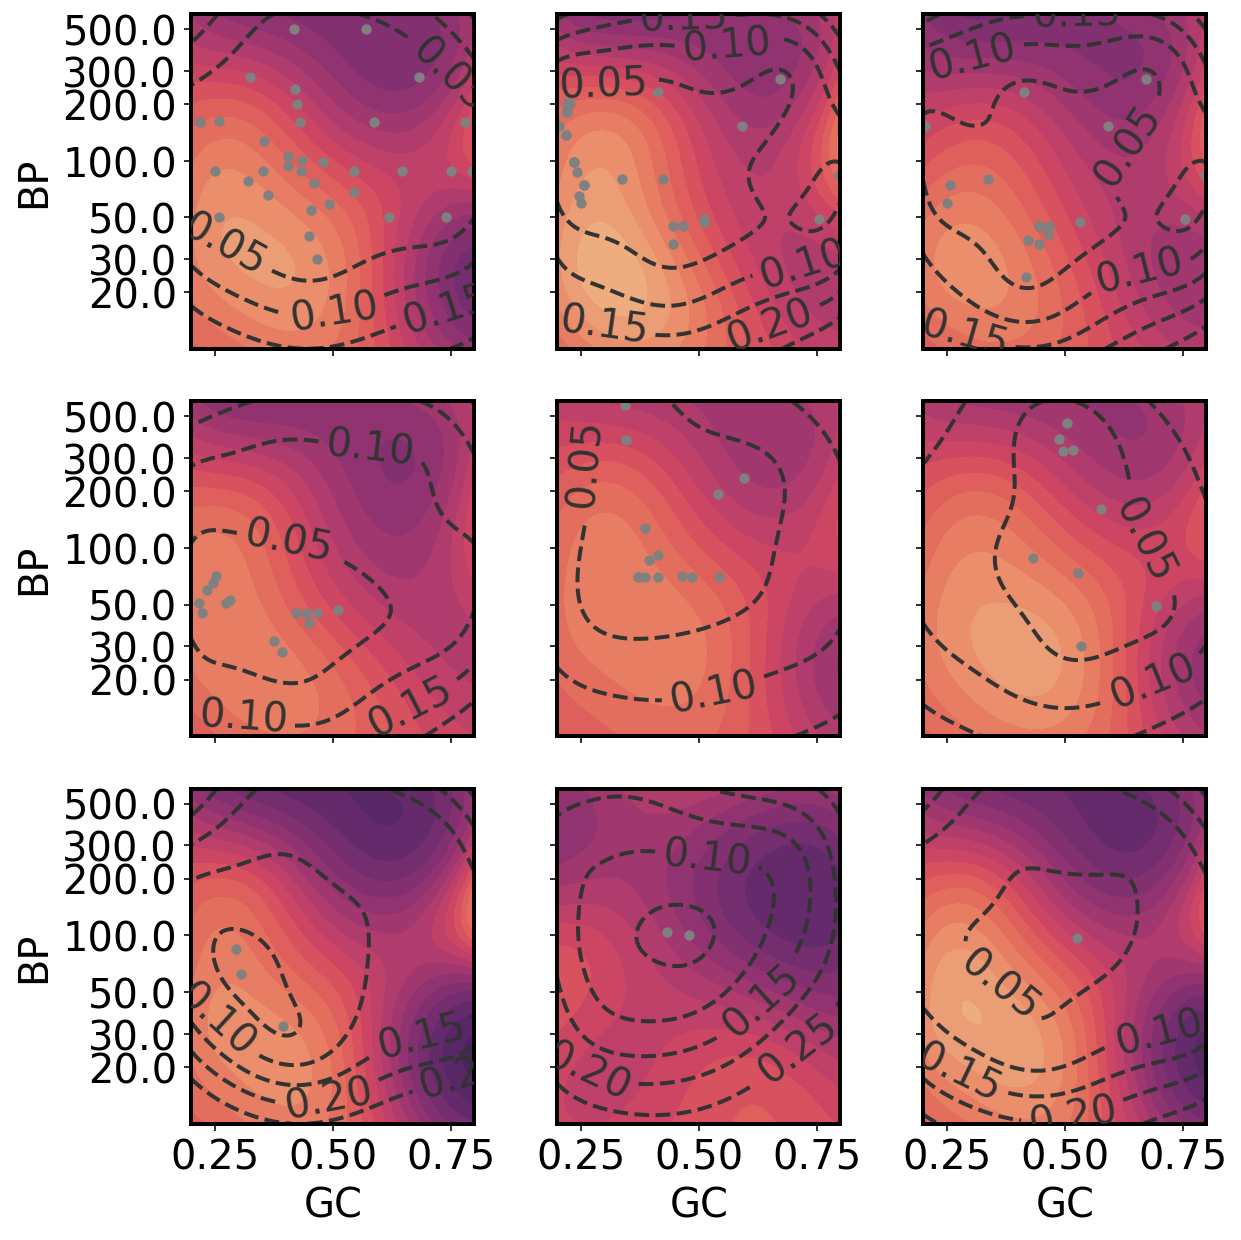

In [9]:
rnorm = mpl.colors.Normalize()
rnorm(np.stack([r.μ for r in all_r]));

fig, axs = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

for i, (r, ax, row) in enumerate(zip(all_r, axs.flat, selected.itertuples())):
    
    plt.sca(ax)
    pp = gmb.ParrayPlotter(x=GC, y=BP, z=r, 
                        #    x_scale='standardized',
                           y_scale='standardized'
                           )

    step = 0.05
    levels=np.arange(np.floor(rnorm.vmin/step), np.ceil(rnorm.vmax/step)+1)*step
    cs = pp(plt.contourf, levels=levels, cmap='flare_r', norm=rnorm)
    # pp.colorbar(cs)

    yticks = gp.parray(BP=[20, 30, 50, 100, 200, 300, 500])
    ax.set_yticks(yticks['BP'].z.values())
    ax.set_yticklabels(yticks.values())
    
    if i%3 != 0:
        ax.set_ylabel('')
    if i//3 != 2:
        ax.set_xlabel('')

    gc = (ds.wide
          .query('Reporter == @row.Reporter and PrimerPair == @row.PrimerPair')
          .GC
         )
    bp = (ds.wide.z
          .query('Reporter == @row.Reporter and PrimerPair == @row.PrimerPair')
          .BP
         )

    ax.scatter(gc, bp, c='0.5', cmap='flare_r', norm=rnorm, s=10)

    ax.set_xlim(limits['GC'].values())

    cs = ax.contour(GC.values(), BP.z.values(), r.σ, levels=[0.05, 0.10, 0.15, 0.20, 0.25], colors='0.2', linestyles='--')
    ax.clabel(cs);
    
plt.tight_layout()